<a href="https://colab.research.google.com/github/fernandogarade/CEIA_09_NLP/blob/main/Desafio_clase_2_NLP_Chatbot_para_CX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 - Instalar dependencias

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

# 2 - Importar librerías

In [2]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

import stanza
import spacy_stanza

import re
import unicodedata

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import nltk
from nltk.corpus import stopwords

In [3]:
# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")
nltk.download('stopwords')

2021-09-21 02:13:56 INFO: Downloading default packages for language: es (Spanish)...
2021-09-21 02:13:58 INFO: File exists: /root/stanza_resources/es/default.zip.
2021-09-21 02:14:05 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-09-21 02:14:05 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2021-09-21 02:14:05 INFO: Use device: cpu
2021-09-21 02:14:05 INFO: Loading: tokenize
2021-09-21 02:14:05 INFO: Loading: mwt
2021-09-21 02:14:05 INFO: Loading: pos
2021-09-21 02:14:06 INFO: Loading: lemma
2021-09-21 02:14:06 INFO: Loading: depparse
2021-09-21 02:14:06 INFO: Loading: ner
2021-09-21 02:14:08 INFO: Done loading processors!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Funciones útiles
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * (np.linalg.norm(b)))

def OHE(x,vocab):
  vector_ohe = [1 if i in x else 0 for i in vocab ]
  vector_ohe = np.array(vector_ohe)
  return vector_ohe

def FreqVector(x,vocab):
  c = Counter(x)
  vector_frec = [c[i] for i in vocab ]
  vector_frec = np.array(vector_frec)
  return vector_frec

# 3 - Preprocesamiento de datos

In [5]:
# El preprocesamento en castellano requiere más trabajo

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # quitar caracteres especiales y números
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)

    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])

    return text

# 4 - Diccionario de entrada

In [6]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?", "¿Qué haces?", "Buen día", "Buenas tardes", "Buenas noches"],
              "responses": ["Hola!", "Hola, ¿Cómo estás?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?", "¿Con quién estoy hablando?"],
              "responses": ["Mi nombre es TiendaPro", "Yo soy TiendaPro"]
             },
            {"tag": "problemas promos",
              "patterns": ["No me pagaron la promo", "Recomendé y no me pagaron", "Problema", "inconveniente"],
              "responses": ["Lamentamos saber que tuviste un problema con la promo, por favor al siguiente número 1112221133", "Contactanos al whatsapp 1112221133 para revisar tu caso en forma particular"]
             },
            {"tag": "info promos",
              "patterns": ["¿Cómo funciona la promo?", "¿Cómo tengo que hacer para referir a alguien?", "¿Cuándo me pagan?", "¿Hasta cuándo está vigente?", "¿Cuándo termina la promo?"],
              "responses": ["Encontrá todos los detalles de nuestras promos en el siguiente link: abc123.com"]
             },
            {"tag": "costo",
              "patterns": ["costo", "precio", "¿Cuánto vale?", "¿Cuánto sale?", "¿Tengo que pagar algo?", "gratis"],
              "responses": ["El servicio es GRATIS!"]
             },
            {"tag": "registro",
              "patterns": ["registro", "darse de alta", "¿Cómo me doy de alta?", "¿Dónde me inscribo?"],
              "responses": ["En el siguiente link podrás encontrar un instructivo para registrarte fácilmente"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme nuevamente"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!", "Nos vemos"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

# 5 - Preprocesamiento y armado del dataset

In [7]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
nltk_stop_words = set(stopwords.words("spanish"))

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            if token.lemma_ not in nltk_stop_words:
              words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [8]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)
# Tamaño del vocabulario
print("Vocabulario:", len(words))

words: ['alguien', 'alta', 'buen', 'chau', 'costo', 'cuanto', 'dar', 'dia', 'funcionar', 'gracias', 'gratis', 'hablar', 'hacer', 'holar', 'inconveniente', 'inscribir', 'luego', 'noche', 'nombre', 'pagar', 'precio', 'problema', 'promo', 'recomendar', 'referir', 'registro', 'salir', 'ser', 'tal', 'tarde', 'tener', 'terminar', 'valer', 'ver', 'vigente']
classes: ['agradecimientos', 'bienvenida', 'costo', 'despedida', 'info promos', 'nombre', 'problemas promos', 'registro']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Qué haces?', 'Buen día', 'Buenas tardes', 'Buenas noches', '¿Cúal es tu nombre?', '¿Quién sos?', '¿Con quién estoy hablando?', 'No me pagaron la promo', 'Recomendé y no me pagaron', 'Problema', 'inconveniente', '¿Cómo funciona la promo?', '¿Cómo tengo que hacer para referir a alguien?', '¿Cuándo me pagan?', '¿Hasta cuándo está vigente?', '¿Cuándo termina la promo?', 'costo', 'precio', '¿Cuánto vale?', '¿Cuánto sale?', '¿Tengo que pagar algo?', 'gratis', 'registro', 'darse d

In [9]:
# Opción con TF-IDF
# Transformar doc_X en TF_IDF
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

vocab = words
corpus = doc_X

corpus_terminos = []
for doc in corpus:
  tokens = nlp(preprocess_clean_text(doc.lower()))
  terminos = []
  for token in tokens:
      if token.lemma_ not in nltk_stop_words:
        terminos.append(token.lemma_)
  
  corpus_terminos.append(terminos)

N = len(corpus)
ohe = np.zeros((len(corpus),len(vocab)))
TF = np.zeros((len(corpus),len(vocab)))
i = 0
for doc in corpus_terminos:
  ohe[i] = OHE(doc,vocab)
  TF[i] = FreqVector(doc,vocab)
  i += 1

DF = np.sum(ohe,axis=0)
IDF = np.log10(N/DF)
TF_IDF = TF*IDF

In [10]:
ohe_y = np.zeros(shape=(len(doc_y),len(classes)))
i = 0
for doc in doc_y:
  ohe_y[i] = OHE(doc,classes)
  i += 1

In [11]:
x_train = TF_IDF
y_train = ohe_y

In [12]:
x_train.shape

(34, 35)

In [13]:
y_train.shape

(34, 8)

# 6 - Entrenamiento del modelo

In [14]:
# Shape de entrada y salida
input_shape = (x_train.shape[1],)
output_shape = y_train.shape[1]

# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4608      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
Total params: 13,384
Trainable params: 13,384
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
hist = model.fit(x=x_train, y=y_train, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 9ms/step - loss: 2.1013 - accuracy: 0.1765
Epoch 2/200
2/2 [==============================] - 0s 19ms/step - loss: 2.0794 - accuracy: 0.1765
Epoch 3/200
2/2 [==============================] - 0s 15ms/step - loss: 2.1649 - accuracy: 0.0294
Epoch 4/200
2/2 [==============================] - 0s 20ms/step - loss: 2.0227 - accuracy: 0.2941
Epoch 5/200
2/2 [==============================] - 0s 7ms/step - loss: 2.0787 - accuracy: 0.1471
Epoch 6/200
2/2 [==============================] - 0s 20ms/step - loss: 2.0069 - accuracy: 0.2647
Epoch 7/200
2/2 [==============================] - 0s 10ms/step - loss: 2.0045 - accuracy: 0.2647
Epoch 8/200
2/2 [==============================] - 0s 25ms/step - loss: 2.0443 - accuracy: 0.0882
Epoch 9/200
2/2 [==============================] - 0s 24ms/step - loss: 1.9683 - accuracy: 0.1765
Epoch 10/200
2/2 [==============================] - 0s 13ms/step - loss: 2.0085 - accuracy: 0.1471
Epoch 11/200
2/2 [===

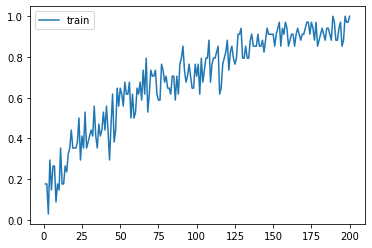

In [16]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [17]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo

import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

# 7 - Testing y validación

In [18]:
def doc_to_terminos(doc):
  tokens = nlp(preprocess_clean_text(doc.lower()))
  terminos = []
  for token in tokens:
      if token.lemma_ not in nltk_stop_words:
        terminos.append(token.lemma_)
  return terminos


def calc_TF_IDF(doc,vocab,IDF):
  terminos = doc_to_terminos(doc)
  TF = FreqVector(terminos,vocab)
  TF_IDF = TF*IDF
  
  return TF_IDF

def pred_class(doc,vocab,labels,IDF):
  TF_IDF = calc_TF_IDF(doc,vocab,IDF)
  words_recognized = sum(TF_IDF)

  return_list = []
  if words_recognized > 0:
    result = model.predict(np.array([TF_IDF]))[0]
    thresh = 0.2
    y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
    y_pred.sort(key=lambda x: x[1], reverse=True)

    for r in y_pred:
      return_list.append(labels[r[0]])
      #print(labels[r[0]], r[1])

  return return_list

def get_response(intents_list, intents_json):
  tag = intents_list[0]
  list_of_intents = intents_json["intents"]
  for i in list_of_intents: 
      if i["tag"] == tag:
          result = "BOT: " + random.choice(i["responses"])
          break
  return result

In [19]:
while True:
    message = input("")
    intents = pred_class(doc=message, vocab=vocab, labels=classes,IDF=IDF)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")

Buen día
BOT: Hola!
Quién está ahí?
Perdón, no comprendo la pregunta.
Quién
Perdón, no comprendo la pregunta.
Cómo es tu nombre
BOT: Mi nombre es TiendaPro
Quién sos
BOT: Mi nombre es TiendaPro
No me pagaron
BOT: Encontrá todos los detalles de nuestras promos en el siguiente link: abc123.com
ok hasta cuando funciona
BOT: Encontrá todos los detalles de nuestras promos en el siguiente link: abc123.com
tuve un inconveniente
BOT: Contactanos al whatsapp 1112221133 para revisar tu caso en forma particular
ok pero tengo que pagar algo?
BOT: El servicio es GRATIS!
Buenísimo y cómo me anoto?
Perdón, no comprendo la pregunta.
que como me registro
BOT: En el siguiente link podrás encontrar un instructivo para registrarte fácilmente
Buenísimo muchas gracias
BOT: Por nada!, cualquier otra consulta podes escribirme nuevamente
Dale genial hasta luego


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['da', 'ele', 'genial', 'hasta', 'luego']
Entities: []
  


BOT: Hasta luego!


KeyboardInterrupt: ignored